In [53]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from dateutil import parser
import datetime
from numpy import convolve

from wordcloud import WordCloud, STOPWORDS
from spacy.en import English

# nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import nltk
from nltk.corpus import stopwords

# gensim
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.utils import lemmatize
from gensim.corpora import Dictionary

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

#sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as vaderSentiment
from textblob import TextBlob

# visualization
import pyLDAvis

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


%matplotlib inline

In [54]:
nlp = spacy.load('en')

In [55]:
sns.set_style("whitegrid")

### Import databases

In [56]:
file = open("reviews_coolsculpting.obj",'rb')
reviews_nose = pickle.load(file)
file.close()

In [57]:
new_reviews = []
new_review = {}

for review in reviews_nose:
    for post in review['posts']:
        new_review = {}
        new_review['title'] = review['title']
        new_review['breadcrumbs'] = review['breadcrumbs']
        new_review['username'] = review['username']
        new_review['worthit'] = review['worthit']
        new_review['price'] = review['price']
        new_review['doctor'] = review['doctor']
        new_review['location'] = review['location']
        new_review['procedure_date'] = review['procedure_date']
        
        new_review['post_title'] = post['title']
        new_review['body'] = post['body']
        new_review['likes'] = post['likes']
        new_review['tags'] = post['tags']
        new_review['post_date'] = post['post_date']
        new_review['days_from_procedure'] = post['days_from_procedure']
        
        new_reviews.append(new_review)
        
reviews_date = new_reviews

In [58]:
reviews = pd.DataFrame(reviews_nose)

In [59]:
df = pd.DataFrame(reviews_date)
df['treatment'] = df['breadcrumbs'].apply(lambda x: x[1])

## Clean the Data

In [60]:
#df = df.drop(['breadcrumbs', 'tags'], axis = 1)

In [61]:
def price_clean(price):
    price = price.replace(",", "").replace("$","")
    if price != "":
        return int(price)
    else:
        return 0
    
def worthit_clean(worthit):
    if (worthit != 'Worth It') and (worthit != 'Not Worth It') and (worthit != 'Not Sure'):
        return ''
    else:
        return worthit
    
def format_date(day):
    return parser.parse(day)

def get_year(day):
    return day.year

In [62]:
reviews['worthit'] = reviews['worthit'].apply(worthit_clean)
df['worthit'] = df['worthit'].apply(worthit_clean)
worthit = [reviews[reviews['worthit'] == "Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Worth It"]['worthit'].count(), reviews[reviews['worthit'] == "Not Sure"]['worthit'].count()] 

print("treatment: {}".format(df['treatment'][0]))
print("number of reviews: {}".format(len(reviews)))
print("number of posts: {}".format(len(df)))
print("number of unique users: {}".format(reviews.username.nunique()))
print("number of unique doctors: {}".format(reviews.doctor.nunique()))

treatment: CoolSculpting
number of reviews: 3135
number of posts: 7027
number of unique users: 3124
number of unique doctors: 1661


In [63]:
df = df[df['procedure_date'] != "None"]
df['post_date'] = df['post_date'].apply(format_date)
df['post_year'] = df['post_date'].apply(get_year)
df_per_year = df.groupby(['post_year']).count()
df_per_year = df_per_year['body'].reset_index()

## Topic Modelling (LDA)

In [64]:
def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [65]:
## Takes 5 min
df['body_lem'] = df['body'].apply(get_tokens)

In [66]:
def print_top_words(model, feature_names, n_top_words = 50):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print ("\nTopic #%d:" % topic_idx)
        print (", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [67]:
#stop words dictionary
nltk_stopwords = stopwords.words('english')+["did", "inner", "outer", "arms","treatment", "procedure", "I", "done", "coolsculpting", "area", "day", 'fat', "cool sculpting", "pain", "results", "get", "would", "sculpting", "like", "abdomen","handles", "stomach", "lower", "love", "thighs", "legs","per", "cool","made", "went", "go", "coolsculpt", "belly", "still", "little","dont","pron", "handle", "i'm", "upper", "one"]

no_features = 1000
no_topics = 5
no_top_words = 30


In [68]:
# with count vectorizer
def get_topics_lda(df, n_topics):   
    count_vect = CountVectorizer(analyzer = "word",
                                       stop_words = nltk_stopwords,
                                       max_features = 1000, 
                                       max_df = 0.8,
                                       min_df = 10,
                                ngram_range = (1,3))
    matrix = count_vect.fit_transform(df)
    vocab = count_vect.get_feature_names()


    # fit transform lda
    lda = LatentDirichletAllocation(n_components=n_topics,
                learning_method='online', learning_offset=50., max_iter=10,
                random_state=0)
    
    doc_topic_dists = lda.fit_transform(matrix)
    
    # print topic words
    print_top_words(lda, vocab)
    
    # prepare pyLDAvis 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = df.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [69]:
## Takes 10 min
all_lda, all_doc_topics, all_prepared = get_topics_lda(df['body'], 5)


Topic #0:
see, months, money, think, lipo, time, know, said, difference, told, month, tummy, really, worth, another, work, change, could, second, back, want, even, look, good, since, much, photos, top, say, tell, weeks, waste, people, muffin, first, treatments, muffin top, thought, wish, need, tuck, wait, ago, disappointed, nothing, tummy tuck, take, let, something, going

Topic #1:
weeks, see, two, areas, days, treated, side, numbness, post, right, since, week, left, difference, swelling, arm, gone, feel, ago, three, time, bruising, smaller, second, first, wait, much, far, already, bit, flanks, two weeks, months, seeing, numb, looks, better, small, couple, notice, really, noticed, feeling, slight, change, abdominal, almost, month, less, discomfort

Topic #2:
felt, minutes, numb, days, feel, first, painful, uncomfortable, really, today, feeling, time, bad, massage, 10, much, swollen, back, took, night, skin, applicator, swelling, suction, hurt, bit, sore, hour, got, side, take, also, 

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [108]:
pyLDAvis.display(all_prepared)

In [71]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

In [72]:
# categorize reviews by most probable topic
df['topic_LDA'] = get_doc_topics(all_doc_topics)

In [73]:
def get_doc_topics_relevant(doc_topic_dist):
    for doc, topic in enumerate(doc_topic_dist):
        if max(topic) > 0.7:
            return (np.argmax(topic))
        else:
            return (-1)
        
topic_LDA_relevant = []
for doc, topic in enumerate(all_doc_topics):
    if max(topic) > 0.7:
        topic_LDA_relevant.append(np.argmax(topic))
    else:
        topic_LDA_relevant.append(-1)
        
# categorize reviews by most probable topic (>0.7)
df['topic_LDA_relevant'] = topic_LDA_relevant

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


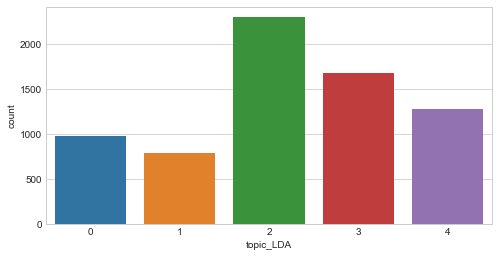

In [74]:
plt.figure(figsize = (8,4))
sns.countplot('topic_LDA', data = df)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


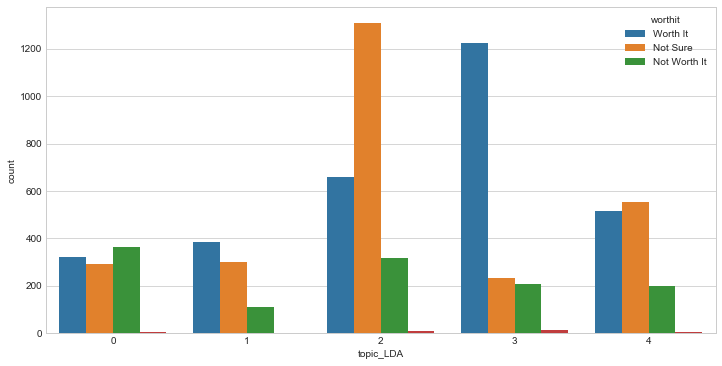

In [75]:
plt.figure(figsize = (12,6))
sns.countplot('topic_LDA', data = df, hue = "worthit")

#### Organize periods

In [76]:
df['days_from_procedure'] = df[df['days_from_procedure'] <= 700]['days_from_procedure']
df['weeks_from_procedure'] = round(df['days_from_procedure'] / 7,0)
#df = df[df['weeks_from_procedure'] >0]

In [77]:
## aggregate days by month
def get_months(day):
    if day >= 365:
        return "over 1 year"
    elif day >= 334:
        return "11"
    elif day >= 303:
        return "10"
    elif day >= 272:
        return "11"
    elif day >= 241:
        return "09"
    elif day >= 211:
        return "08"
    elif day >= 181:
        return "07"
    elif day >= 151:
        return "06"
    elif day >= 121:
        return "05"
    elif day >= 91:
        return "04"
    elif day >= 60:
        return "03"
    elif day >= 30:
        return "02"
    else:
        return "01"
    
df['months_from_procedure'] = df['days_from_procedure'].apply(get_months) 

## Sentiment Analysis

In [78]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [79]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [TextBlob(x).sentiment[0] for x in sents]

#def get_vader_sentiment(text):
#    """Return vaderSentiment score for text."""
#    try:
#        return vaderSentiment(text)['compound']
#    except:
#        return 0

In [80]:
df['sentences'] = df['body'].apply(get_sentences)

In [81]:
## Takes 5 min

df['sentiment_scores'] = df['sentences'].apply(get_polarity)

In [82]:
df['avg_sentiment'] = df['sentiment_scores'].apply(np.mean)

/Users/nataliabernardo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [83]:
def sentiment_threshold(sentiment):
    if sentiment > 0.0:
        return "positive"
    elif sentiment < 0.0:
        return "negative"
    else:
        return "neutral"
    
df['sentiment'] = df['avg_sentiment'].apply(sentiment_threshold)

Text(0.5,1,'Sentiment Distribution')

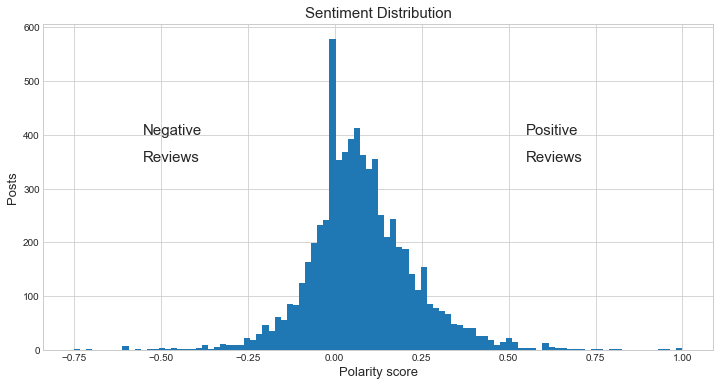

In [84]:
plt.figure(figsize=(12,6))
#sns.plot(df[df['body'] != ""]['avg_sentiment'])
plt.hist(df['avg_sentiment'].dropna(), bins = 100) # ignore NaN's
#plt.axvline(x=-0.05, color="r",linestyle="dashed")
#plt.axvline(x=0.05, color="r",linestyle="dashed")

plt.text(0.55, 400, "Positive", fontsize=15)
plt.text(0.55, 350, "Reviews", fontsize=15)
plt.text(-0.55, 400, "Negative", fontsize=15)
plt.text(-0.55, 350, "Reviews", fontsize=15)

plt.xlabel("Polarity score", fontsize=13)
plt.ylabel("Posts", fontsize=13)
plt.title("Sentiment Distribution", fontsize=15)

### Topic Ratings

In [85]:
df_topic0 = df[df['topic_LDA'] == 0]
df_topic1 = df[df['topic_LDA'] == 1]
df_topic2 = df[df['topic_LDA'] == 2]
df_topic3 = df[df['topic_LDA'] == 3]
df_topic4 = df[df['topic_LDA'] == 4]
#df_topic5 = df[df['topic_LDA'] == 5]
#df_topic6 = df[df['topic_LDA'] == 6]

print("topic 0 ocurrences: {}".format(len(df_topic0)))
print("topic 1 ocurrences: {}".format(len(df_topic1)))
print("topic 2 ocurrences: {}".format(len(df_topic2)))
print("topic 3 ocurrences: {}".format(len(df_topic3)))
print("topic 4 ocurrences: {}".format(len(df_topic4)))
#print("topic 5 ocurrences: {}".format(len(df_topic5)))
#print("topic 6 ocurrences: {}".format(len(df_topic6)))

topic 0 ocurrences: 981
topic 1 ocurrences: 796
topic 2 ocurrences: 2297
topic 3 ocurrences: 1676
topic 4 ocurrences: 1277


In [86]:
## Reflecting decision 
perc_positiv_0 = len(df_topic0[df_topic0['sentiment'] == 'positive']['sentiment']) / len(df_topic0.dropna())
print ("Topic 0: {}% of the people review positively". format(round(perc_positiv_0 * 100)))

## Discomfort (swelling/numb/pain)
perc_positiv_1 = len(df_topic1[df_topic1['sentiment'] == 'positive']['sentiment']) / len(df_topic1.dropna())
print ("Topic 1: {}% of the people review positively". format(round(perc_positiv_1 * 100)))

## Surgery/pos op
perc_positiv_2 = len(df_topic2[df_topic2['sentiment'] == 'positive']['sentiment']) / len(df_topic2.dropna())
print ("Topic 2: {}% of the people review positively". format(round(perc_positiv_2 * 100)))

## Overall Reviews
perc_positiv_3 = len(df_topic3[df_topic3['sentiment'] == 'positive']['sentiment']) / len(df_topic3.dropna())
print ("Topic 3: {}% of the people review positively". format(round(perc_positiv_3 * 100)))

## Updates
perc_positiv_4 = len(df_topic4[df_topic4['sentiment'] == 'positive']['sentiment']) / len(df_topic4.dropna())
print ("Topic 4: {}% of the people review positively". format(round(perc_positiv_4 * 100)))

#perc_positiv_5 = len(df_topic5[df_topic5['sentiment'] == 'positive']['sentiment']) / len(df_topic5['sentiment'])
#print ("Topic 5: {}% of the people review positively". format(round(perc_positiv_5 * 100)))

#perc_positiv_6 = len(df_topic6[df_topic6['sentiment'] == 'positive']['sentiment']) / len(df_topic6['sentiment'])
#print ("Topic 6: {}% of the people review positively". format(round(perc_positiv_6 * 100)))

Topic 0: 61% of the people review positively
Topic 1: 71% of the people review positively
Topic 2: 60% of the people review positively
Topic 3: 91% of the people review positively
Topic 4: 71% of the people review positively


#### Ratings for Categories

In [87]:
Procedure = perc_positiv_2
Recovery = (len(df_topic1[df_topic1['sentiment'] == 'positive']['sentiment']) + len(df_topic4[df_topic4['sentiment'] == 'positive']['sentiment'])) / (len(df_topic1.dropna()) + len(df_topic4.dropna())) 
Results = (len(df_topic0[df_topic0['sentiment'] == 'positive']['sentiment']) + len(df_topic3[df_topic3['sentiment'] == 'positive']['sentiment'])) / (len(df_topic0.dropna()) + len(df_topic3.dropna())) 

print ("Procedure: {}% of the people review positively". format(round(Procedure * 100)))
print ("Recovery: {}% of the people review positively". format(round(Recovery * 100)))
print ("Results: {}% of the people review positively". format(round(Results * 100)))

Procedure: 60% of the people review positively
Recovery: 71% of the people review positively
Results: 82% of the people review positively


In [107]:
import csv
with open('viz/results_coolsculpting.csv', 'w') as csvfile:
    csvfile.write('title,rating\n')
    csvfile.write('Procedure,{}\n'.format(Procedure))
    csvfile.write('Recovery,{}\n'.format(Recovery))
    csvfile.write('Results,{}\n'.format(Results))
    csvfile.close()

#### Generate Graphs

In [88]:
def label_topic(topic):
    if (topic == 2):
        return 'Procedure'
    elif (topic == 1) or (topic == 4):
        return 'Recovery'
    elif (topic == 0) or (topic == 3):
        return 'Result'
    else:
        return 'Recovery'
df['topic_label'] = df['topic_LDA'].apply(label_topic)

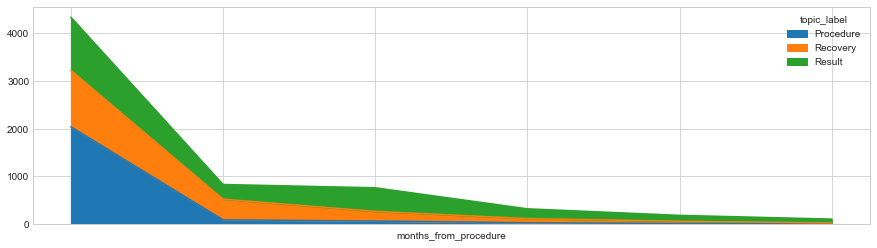

In [89]:
df_period_labels = df.groupby(['months_from_procedure','topic_label'])
df_count_posts_labels = df_period_labels.topic_LDA.count()
df_count_posts_labels = df_count_posts_labels.unstack()

## Pplot graph
df_count_posts_labels[:6].plot.area(figsize=(15,4))

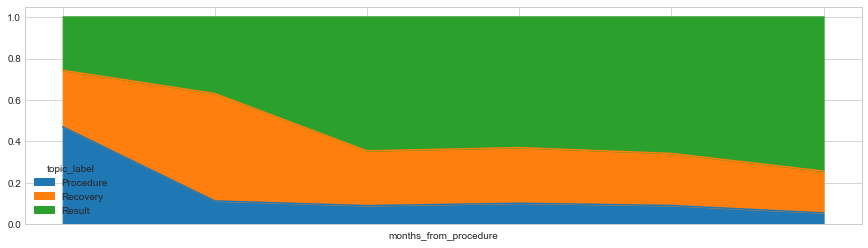

In [90]:
topic_perc_labels = df_count_posts_labels.divide(df_count_posts_labels.sum(axis=1), axis=0)
topic_perc_labels[:6].plot.area(figsize=(15,4))

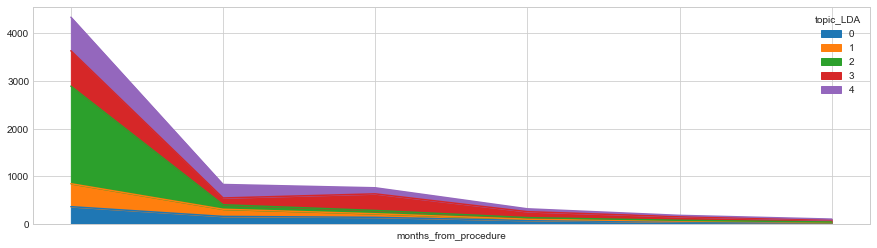

In [91]:
df_period = df.groupby(['months_from_procedure','topic_LDA'])
df_count_posts = df_period.topic_LDA.count()
df_count_posts = df_count_posts.unstack()

## Pplot graph
df_count_posts[:6].plot.area(figsize=(15,4))

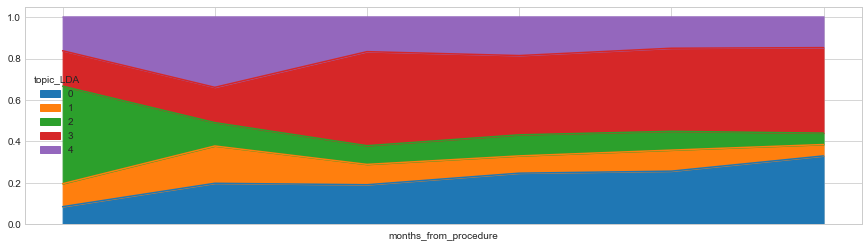

In [92]:
topic_perc = df_count_posts.divide(df_count_posts.sum(axis=1), axis=0)
topic_perc[:6].plot.area(figsize=(15,4))

#### Save DataFrame

In [93]:
pickle.dump(df, open("reviews_topics_coolsculpting.pickle",'wb'))

In [94]:
df.to_csv("reviews_topics_coolsculpting.csv", encoding='utf-8', index=False)